# Sentiment in FOMC statements

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import date
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt
from skfin.plot import bar, line
from tqdm.auto import tqdm

import numpy as np
from pandas.tseries.offsets import BDay
from skfin.datasets_ import load_kf_returns
from skfin.text import show_text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.pipeline import Pipeline

## Supervised learning: vector representation + Elastic net

In this section, we use the corpus of FOMC statements for supervised learning. More precisely, we match the text of the statements to the decision of the committee to raise rates, decrease rates or do nothing.  

In practice, this implemented by using `scikit-learn pipelines` and chaining the `TfidfVectorizer` with a logistic regression. 

In [2]:
from skfin.datasets_ import load_fomc_statements
from skfin.dataloaders.constants.dates import load_fomc_change_date

statements = load_fomc_statements(force_reload=False)

fomc_change_up, fomc_change_dw = load_fomc_change_date()

INFO:skfin.dataloaders.cache:Loading from cache : data/fomc_statements.parquet


In [3]:
fomc_change_up, fomc_change_dw

(DatetimeIndex(['1999-06-30', '1999-08-24', '1999-11-16', '2000-02-02',
                '2000-03-21', '2000-05-16', '2004-06-30', '2004-08-10',
                '2004-09-21', '2004-11-10', '2004-12-14', '2005-02-02',
                '2005-03-22', '2005-05-03', '2005-06-30', '2005-08-09',
                '2005-09-20', '2005-11-01', '2005-12-13', '2006-01-31',
                '2006-03-28', '2006-05-10', '2006-06-29', '2015-12-16',
                '2016-12-14', '2017-03-15', '2017-06-14', '2017-12-13',
                '2018-03-21', '2018-06-13', '2018-09-26', '2018-12-19',
                '2022-03-16', '2022-05-04', '2022-06-15', '2022-07-27'],
               dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2001-01-03', '2001-01-31', '2001-03-20', '2001-04-18',
                '2001-05-15', '2001-06-27', '2001-08-21', '2001-09-17',
                '2001-10-02', '2001-11-06', '2001-12-11', '2002-11-06',
                '2003-06-25', '2007-09-18', '2007-10-31', '2007-12-11',
            

In [4]:
other = {
    "other_dt_change": ["2003-01-09", "2008-03-16", "2011-06-22"],
    "statements_dt_change_other": ["2007-08-16"],
    "qe1": ["2008-11-25", "2008-12-01", "2008-12-16", "2009-03-18"],
    "qe2": ["2010-11-03"],
    "twist": ["2011-09-21", "2012-06-20"],
    "qe3": ["2012-09-13", "2012-12-12", "2013-12-13"],
    "corona": ["2020-03-20"],
}

In [5]:
dates = {
    "up": fomc_change_up,
    "dw": fomc_change_dw,
    "other": [d for c in other.values() for d in c],
}
dates["no change"] = statements.index.difference([d for c in dates.values() for d in c])

In [6]:
from skfin.text import coefs_plot, show_text
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.preprocessing import FunctionTransformer

In [7]:
est = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                vocabulary=None,
                ngram_range=(1, 3),
                max_features=500,
                stop_words="english",
                token_pattern=r"\b[a-zA-Z]{3,}\b",
            ),
        ),
        ("log1p", FunctionTransformer(np.log1p)),
        (
            "reg",
            LogisticRegression(
                C=1, l1_ratio=0.35, penalty="elasticnet", solver="saga", max_iter=500
            ),
        ),
    ]
)
X, y = pd.concat(
    [
        statements.loc[fomc_change_up].assign(change=1),
        statements.loc[fomc_change_dw].assign(change=-1),
    ]
).pipe(lambda df: (df["text"], df["change"]))
est.fit(X, y)
vocab_ = pd.Series(est.named_steps["tfidf"].vocabulary_).sort_values().index

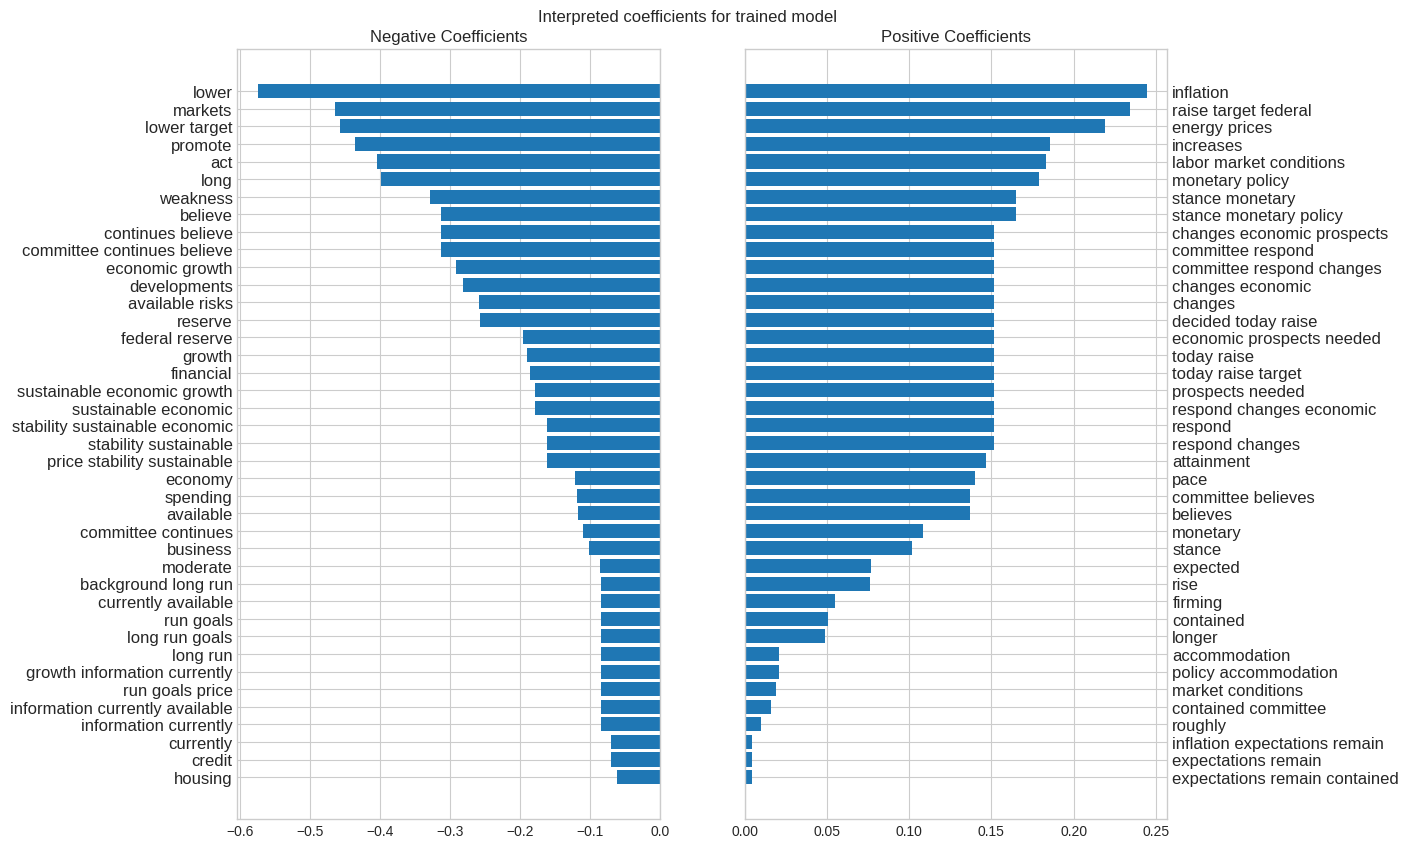

In [8]:
interpret_coef = pd.DataFrame(np.transpose(est.named_steps["reg"].coef_), index=vocab_)
coefs_plot(interpret_coef, title="Interpreted coefficients for trained model")

A trick is that using a linear regression (e.g. ElasticNet) instead of a logistic regression is faster and as efficient (even sometimes better)

In [9]:
est = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                vocabulary=None,
                ngram_range=(1, 3),
                max_features=500,
                stop_words="english",
                token_pattern=r"\b[a-zA-Z]{3,}\b",
            ),
        ),
        ("log1p", FunctionTransformer(np.log1p)),
        ("reg", ElasticNet(alpha=0.01)),
    ]
)
X, y = pd.concat(
    [
        statements.loc[fomc_change_up].assign(change=1),
        statements.loc[fomc_change_dw].assign(change=-1),
    ]
).pipe(lambda df: (df["text"], df["change"]))
est.fit(X, y)
vocab_ = pd.Series(est.named_steps["tfidf"].vocabulary_).sort_values().index

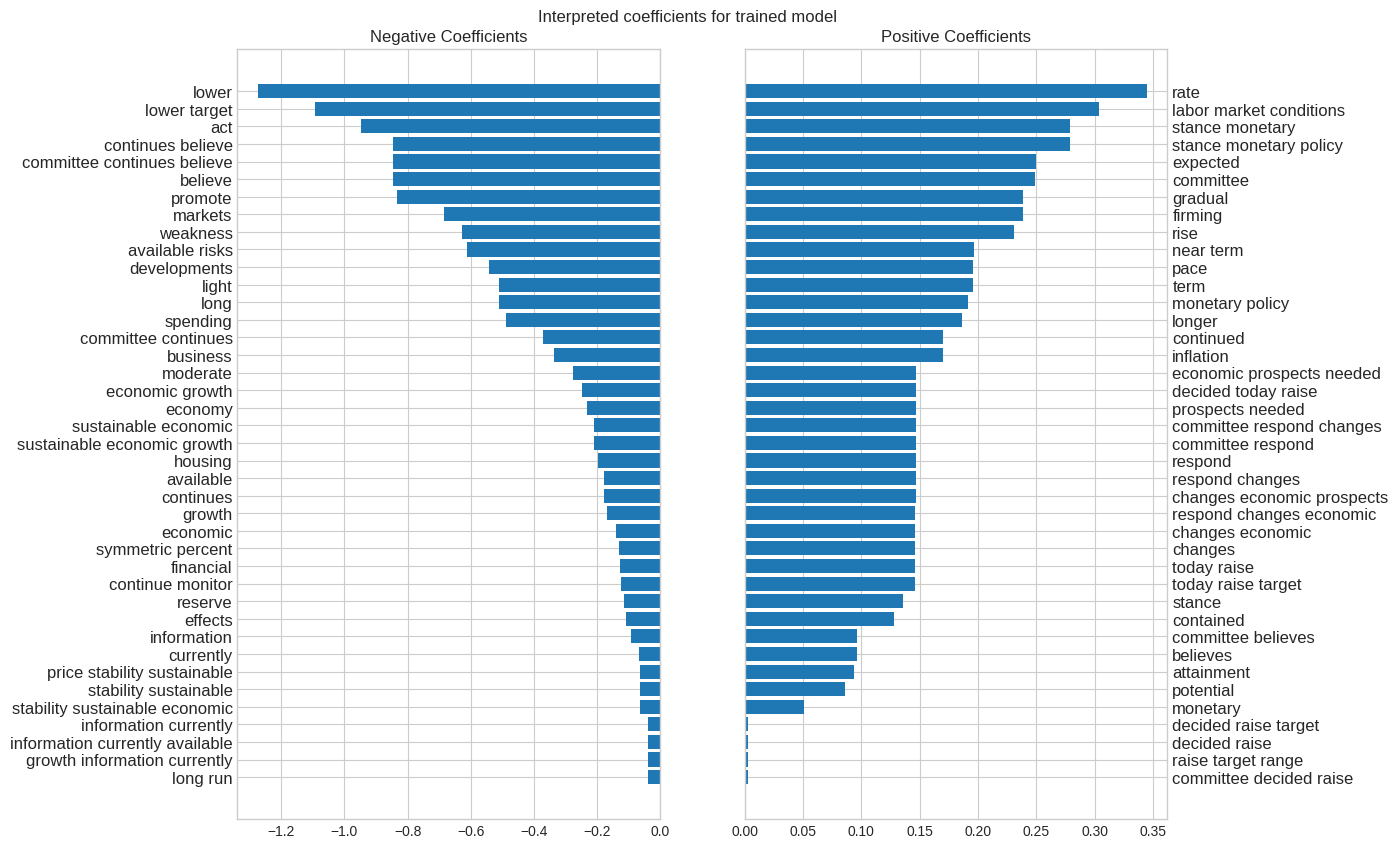

In [10]:
interpret_coef = pd.DataFrame(np.transpose(est.named_steps["reg"].coef_), index=vocab_)
coefs_plot(interpret_coef, title="Interpreted coefficients for trained model")

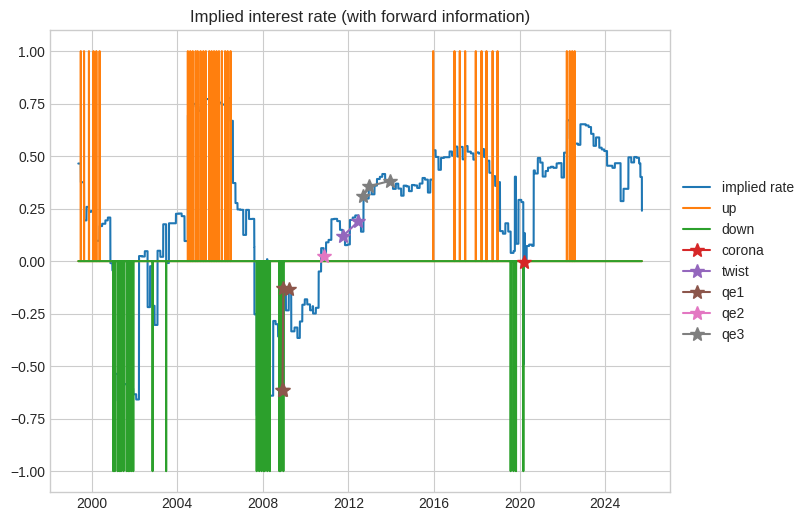

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
pred_tfidf = (
    pd.Series(est.predict(statements["text"]), index=statements.index)
    .resample("B")
    .last()
    .ffill()
)
line(
    pred_tfidf.rename("implied rate")
    .to_frame()
    .join(
        pd.Series(1, index=fomc_change_up)
        .reindex(pred_tfidf.index)
        .fillna(0)
        .rename("up")
    )
    .join(
        pd.Series(-1, index=fomc_change_dw)
        .reindex(pred_tfidf.index)
        .fillna(0)
        .rename("dw")
    ),
    sort=False,
    ax=ax,
    title="Implied interest rate (with forward information)",
)
cols = ["corona", "twist", "qe1", "qe2", "qe3"]
for c in cols:
    ax.plot(pred_tfidf.loc[other[c]], marker="*", ms=10)
ax.legend(
    ["implied rate", "up", "down"] + cols, loc="center left", bbox_to_anchor=(1, 0.5)
);

In [12]:
lexica = {
    "positive": interpret_coef.squeeze().nlargest(n=10),
    "negative": interpret_coef.squeeze().nsmallest(n=10),
}

In [13]:
idx_ = (
    pd.Series(est.predict(X), index=X.index)
    .sort_values()
    .pipe(lambda x: [x.index[0], x.index[-1]])
)
show_text(statements.loc[idx_], lexica=lexica, n=None)

,last_update,text,voting,release_time,url
release_date,,,,,
2007-09-18,2007-09-18,"The Federal Open Market Committee decided today to lower its target for the federal funds rate 50 basis points to 4-3/4 percent. Economic growth was moderate during the first half of the year, but the tightening of credit conditions has the potential to intensify the housing correction and to restrain economic growth more generally. Todayâs action is intended to help forestall some of the adverse effects on the broader economy that might otherwise arise from the disruptions in financial markets and to promote moderate growth over time. Readings on core inflation have improved modestly this year. However, the Committee judges that some inflation risks remain, and it will continue to monitor inflation developments carefully. Developments in financial markets since the Committeeâs last regular meeting have increased the uncertainty surrounding the economic outlook. The Committee will continue to assess the effects of these and other developments on economic prospects and will act as needed to foster price stability and sustainable economic growth.","Voting for the FOMC monetary policy action were: Ben S. Bernanke, Chairman; Timothy F. Geithner, Vice Chairman; Charles L. Evans; Thomas M. Hoenig; Donald L. Kohn; Randall S. Kroszner; Frederic S. Mishkin; William Poole; Eric Rosengren; and Kevin M. Warsh.",For immediate release,https://www.federalreserve.gov/newsevents/press/monetary/20070918a.htm
2005-03-22,2005-03-22,"The Federal Open Market Committee decided today to raise its target for the federal funds rate by 25 basis points to 2-3/4 percent. The Committee believes that, even after this action, the stance of monetary policy remains accommodative and, coupled with robust underlying growth in productivity, is providing ongoing support to economic activity. Output evidently continues to grow at a solid pace despite the rise in energy prices, and labor market conditions continue to improve gradually. Though longer-term inflation expectations remain well contained, pressures on inflation have picked up in recent months and pricing power is more evident. The rise in energy prices, however, has not notably fed through to core consumer prices. The Committee perceives that, with appropriate monetary policy action, the upside and downside risks to the attainment of both sustainable growth and price stability should be kept roughly equal. With underlying inflation expected to be contained, the Committee believes that policy accommodation can be removed at a pace that is likely to be measured. Nonetheless, the Committee will respond to changes in economic prospects as needed to fulfill its obligation to maintain price stability.","Voting for the FOMC monetary policy action were: Alan Greenspan, Chairman; Timothy F. Geithner, Vice Chairman; Ben S. Bernanke; Susan S. Bies; Roger W. Ferguson, Jr.; Edward M. Gramlich; Jack Guynn; Donald L. Kohn; Michael H. Moskow; Mark W. Olson; Anthony M. Santomero; and Gary H. Stern.",,https://www.federalreserve.gov/boarddocs/press/monetary/2005/20050322/default.htm


### comparison with sentence transformer embeddings

To test the usefulness of these `SentenceTransformer` , we run a regression of the embeddings on the rate decision. Warning: this is a full sample regression, so this is just an illustration, not a statistical test. 

In [14]:
from sentence_transformers import SentenceTransformer

lm_name = "all-distilroberta-v1"
m = SentenceTransformer(lm_name, device="cpu", trust_remote_code=True)
X_sbert = m.encode(statements["text"].values, batch_size=2)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-distilroberta-v1


Batches:   0%|          | 0/114 [00:00<?, ?it/s]

In [15]:
df = pd.DataFrame(X_sbert, index=statements.index)
m = ElasticNet(alpha=0.01)
X_, y_ = pd.concat(
    [df.loc[fomc_change_up].assign(change=1), df.loc[fomc_change_dw].assign(change=-1)]
).pipe(lambda df: (df.drop("change", axis=1), df["change"]))
m.fit(X_, y_)
pred_sbert = (
    pd.Series(m.predict(df), index=statements.index).resample("B").last().ffill()
)

In [16]:
corr_tfidf_sbert = (
    pd.concat({"sbert": pred_sbert, "tdfidf": pred_tfidf}, axis=1).corr().iloc[0, 1]
)
print(
    f"The correlation of the in-sample prediction for the decisions of the Fed for the two text representations (tfidf and sbert) is {corr_tfidf_sbert:.2f}."
)

The correlation of the in-sample prediction for the decisions of the Fed for the two text representations (tfidf and sbert) is 0.68.


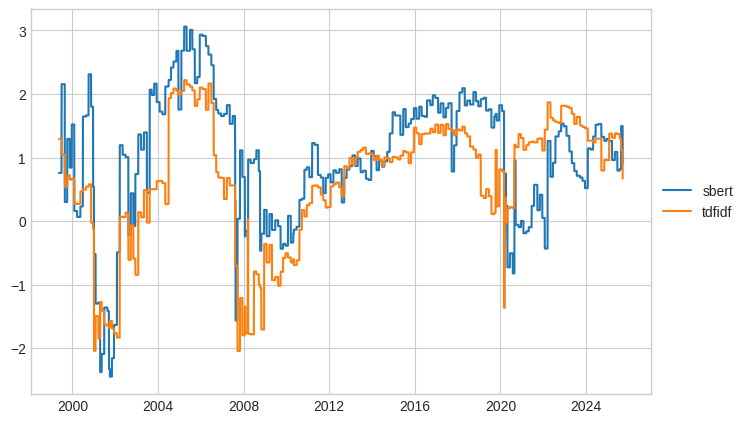

In [17]:
line(
    pd.concat({"sbert": pred_sbert, "tdfidf": pred_tfidf}, axis=1).pipe(
        lambda x: x.div(x.std())
    )
)

## Sentiment in FOMC statements: supervised learning

Building on previous analyses, we build here a `scikit-learn pipeline` with a `Tfidfvectorizer` and a regularized regression`ElasticNet`. The target is the return of the market on the day of the statement. 

In [18]:
ret = load_kf_returns(filename="F-F_Research_Data_Factors_daily")["Daily"]

INFO:skfin.dataloaders.cache:Loading from cache : data/F-F_Research_Data_Factors_daily


In [19]:
special_days = ["2008-01-22", "2010-05-09", "2020-03-15"]
idx0 = pd.to_datetime(pd.Index(special_days))
idx = statements.index.difference(idx0).union(idx0 + BDay(1))
ret_fomc = ret.div(ret.ewm(252).std()).loc[ret.index.intersection(idx)]

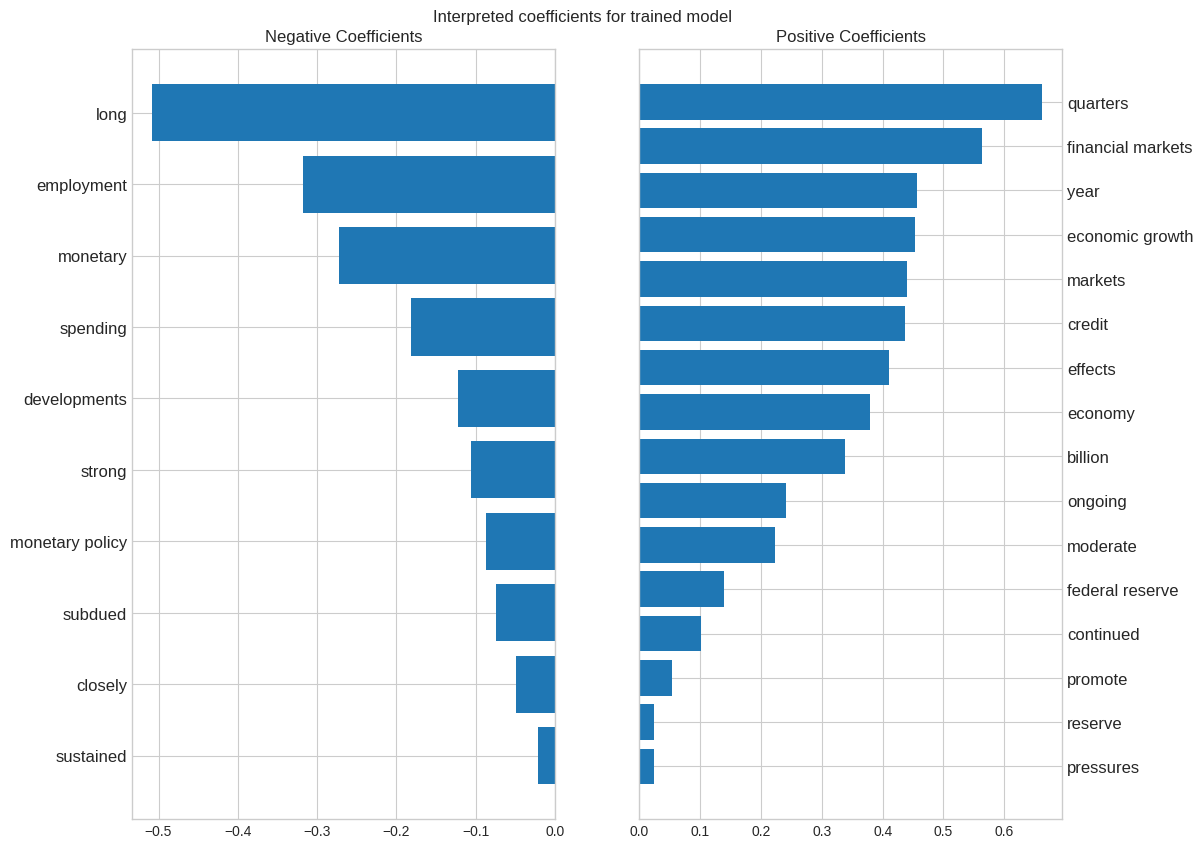

In [20]:
est = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                vocabulary=None,
                ngram_range=(1, 3),
                max_features=500,
                stop_words="english",
                token_pattern=r"\b[a-zA-Z]{3,}\b",
            ),
        ),
        ("reg", ElasticNet(alpha=0.0075)),
    ]
)
y = ret_fomc["Mkt-RF"].dropna()
X = statements["text"]
idx_ = y.index.intersection(X.index)
X, y = X.loc[idx_], y.loc[idx_]
est.fit(X, y)
vocab_ = pd.Series(est.named_steps["tfidf"].vocabulary_).sort_values().index
interpret_coef = pd.DataFrame(np.transpose(est.named_steps["reg"].coef_), index=vocab_)
coefs_plot(interpret_coef, title="Interpreted coefficients for trained model")

In [21]:
lexica = {
    "positive": interpret_coef.squeeze().nlargest(n=10),
    "negative": interpret_coef.squeeze().nsmallest(n=10),
}

In [22]:
idx_ = (
    pd.Series(est.predict(X), index=X.index)
    .sort_values()
    .pipe(lambda x: [x.index[0], x.index[-1]])
)
show_text(statements.loc[idx_], lexica=lexica, n=None)

,last_update,text,voting,release_time,url
release_date,,,,,
2002-01-30,2002-01-30,"The Federal Open Market Committee decided today to keep its target for the federal funds rate unchanged at 1-3/4 percent. Signs that weakness in demand is abating and economic activity is beginning to firm have become more prevalent. With the forces restraining the economy starting to diminish, and with the long-term prospects for productivity growth remaining favorable and monetary policy accommodative, the outlook for economic recovery has become more promising. The degree of any strength in business capital and household spending, however, is still uncertain. Hence, the Committee continues to believe that, against the background of its long-run goals of price stability and sustainable economic growth and of the information currently available, the risks are weighted mainly toward conditions that may generate economic weakness in the foreseeable future.",,,https://www.federalreserve.gov/boarddocs/press/general/2002/20020130/
2007-09-18,2007-09-18,"The Federal Open Market Committee decided today to lower its target for the federal funds rate 50 basis points to 4-3/4 percent. Economic growth was moderate during the first half of the year, but the tightening of credit conditions has the potential to intensify the housing correction and to restrain economic growth more generally. Todayâs action is intended to help forestall some of the adverse effects on the broader economy that might otherwise arise from the disruptions in financial markets and to promote moderate growth over time. Readings on core inflation have improved modestly this year. However, the Committee judges that some inflation risks remain, and it will continue to monitor inflation developments carefully. Developments in financial markets since the Committeeâs last regular meeting have increased the uncertainty surrounding the economic outlook. The Committee will continue to assess the effects of these and other developments on economic prospects and will act as needed to foster price stability and sustainable economic growth.","Voting for the FOMC monetary policy action were: Ben S. Bernanke, Chairman; Timothy F. Geithner, Vice Chairman; Charles L. Evans; Thomas M. Hoenig; Donald L. Kohn; Randall S. Kroszner; Frederic S. Mishkin; William Poole; Eric Rosengren; and Kevin M. Warsh.",For immediate release,https://www.federalreserve.gov/newsevents/press/monetary/20070918a.htm
